2022-03-31 Ludovico Massaccesi

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.special import factorial

# Frequentist interval estimation
Take a Poisson and compute the lower, upper, and central limits for $n=0,\dots,10$.

In [2]:
# Define the Poisson PMF and CDF

def pmf(n, mu):
    """Poisson PMF."""
    return np.exp(-mu) * mu**n / factorial(n)

def cdf(nmin, nmax, mu):
    """Computes the sum of pmf(n,mu) for n in [nmin,nmax]."""
    return np.sum(pmf(np.arange(nmin, nmax+1), mu))

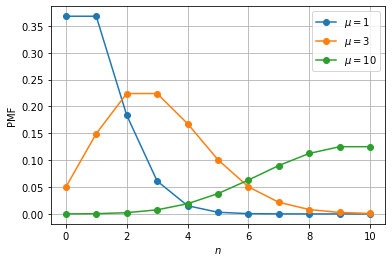

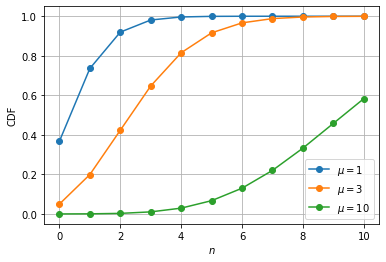

In [3]:
# Check that I wrote them correctly
n = np.arange(11)

plt.figure()
for mu in [1, 3, 10]:
    plt.plot(n, pmf(n, mu), 'o-', label=fr"$\mu={mu:g}$")
plt.grid()
plt.legend()
plt.xlabel("$n$")
plt.ylabel("PMF")
plt.show()

plt.figure()
for mu in [1, 3, 10]:
    plt.plot(n, [cdf(0, i, mu) for i in n], 'o-', label=fr"$\mu={mu:g}$")
plt.grid()
plt.legend()
plt.xlabel("$n$")
plt.ylabel("CDF")
plt.show()

Neyman's bands are defined by requiring that
$$C(\mu)=\sum_{n:o(n)<c}p(n;\mu)\geq CL$$
and solving for $c$, for each value of $\mu$.
The ordering function $o(n)$ is defined by:

1. $o(n)=n$ (sort by $n$ ascending) for the lower limit;
2. $o(n)=-n$ (sort by $n$ descending) for the upper limit;
3. $o(n)=|C(n;\mu)-\frac{1}{2}|$ (sort by distance from the point with cumulant $1/2$ ascending) for the central limit;
4. $o(n)=-P(n;\mu)$ (sort by PMF descending) for the P-ordering limit.

Applying this metod directly requires repeating the procedure for a large number of values of $\mu$ in order to obtain high precision limits.
However, this rapidly becomes very computationally expensive as the required precision increases.

Since, in a real case, $n$ will be fixed by the observation (and, in this exercise, $n$ takes only a limited number of values), one might try to reverse the problem by fixing the last $n$ that will be included in the band (in the order given by $o$), and solve $C(\mu)=CL$ for $\mu$ numerically.

In [4]:
def find_root(f, x1, x2, precision=1e-7):
    """Finds x such that f(x) == 0 within precision,
    using the bisection method in the interval [x1,x2]."""
    if f(x1) == 0 or f(x2) == 0:
        print("INFO One of the extrema is a root.")
        return x1 if f(x1) == 0 else x2
    if f(x1) * f(x2) > 0:
        print("ERROR The function has the same sign at the extrema.")
        print(f"    f({x1}) = {f(x1)}")
        print(f"    f({x2}) = {f(x2)}")
        return np.nan
    x = (x1 + x2) / 2
    while x2-x1 > precision:
        fc = f(x)
        if fc == 0:
            break  # Root found
        if f(x1) * fc < 0:
            x2 = x
        else:
            x1 = x
        x = (x1 + x2) / 2
    return x

In [5]:
n_values = list(range(11))
cl = 0.95

In [6]:
%%time
# Lower limit
lower_limits = []
lower_coverage = []
for n in n_values:
    # No need to sort before doing the sum here
    if n == 0:
        mu_min = 0  # mu_min should be < n, no other solution for n=0
    else:
        mu_min = find_root(lambda mu: cdf(0, n, mu) - cl, 0, n)
    lower_limits.append(mu_min)
    lower_coverage.append((0, n, cdf(0, n, mu_min)))

CPU times: user 15.9 ms, sys: 387 µs, total: 16.2 ms
Wall time: 13 ms


In [7]:
%%time
# Upper limit
upper_limits = []
upper_coverage = []
for n in n_values:
    # Since the sorting is descending from +∞, so I use
    # 1-SUM_FROM_0_TO_n == CL instead
    # Again, no need to sort
    mu_max = find_root(lambda mu: 1 - cdf(0, n, mu) - cl, n, 5*(n+1))
    upper_limits.append(mu_max)
    upper_coverage.append((n, np.inf, 1 - cdf(0, n, mu_max)))

CPU times: user 22.3 ms, sys: 8.56 ms, total: 30.9 ms
Wall time: 22.1 ms


In [8]:
%%time
# Central limits
central_limits = []
central_coverage = []
for n in n_values:
    # Here I can find the two limits of the interval
    # separately using SUM_FROM_0_TO_n == (1-CL)/2
    # and 1-SUM_FROM_0_TO_n == (1-CL/2)
    rhs = (1-cl)/2
    if n == 0:
        # mu_min should be < n, no other solution for n=0
        mu_min = 0
    else:
        mu_min = find_root(
            lambda mu: 1 - cdf(0, n, mu) - rhs, 0, 5*(n+1))
    mu_max = find_root(lambda mu: cdf(0, n, mu) - rhs, 0, 5*(n+1))
    central_limits.append((mu_min, mu_max))
    n_min = next(i for i in range(n,-1,-1) if cdf(i, n, mu_min) >= cl)
    n_max = next(i for i in range(n,32) if cdf(n, i, mu_max) >= cl)
    central_coverage.append((
        (n_min, n, cdf(n_min, n, mu_min)),
        (n, n_max, cdf(n, n_max, mu_max))))

CPU times: user 34.7 ms, sys: 4.29 ms, total: 39 ms
Wall time: 32.4 ms


In [9]:
%%time
# P-ordering limits

# This time I need to sort the n before summing
N_TO_SORT = list(range(100))
def p_ordered_sum(mu, n_min=0, n_max=np.inf, must_include=-1,
                  stop_at=1, return_lims=False):
    """Computes the sum of p(n;μ) for all the n values,
    sorted by p(n;μ) descending, until a value smaller
    than n_min or larger than n_max is found, or
    must_include is reached, or the sum is > stop_at."""
    N_TO_SORT.sort(key=lambda n: -pmf(n, mu))  # Uses timsort
    s = 0.0
    nlow, nup = np.inf, 0
    for n in N_TO_SORT:
        if n < n_min or n > n_max:
            break
        s += pmf(n, mu)
        nlow, nup = min(nlow, n), max(nup, n)
        if n == must_include or s >= stop_at:
            break
    if return_lims:
        return s, nlow, nup
    return s

p_limits = []
p_coverage = []
for n in n_values:
    if n == 0:
        # mu_min should be < n, no other solution for n=0
        mu_min = 0
        mu_max = find_root(
            lambda mu: p_ordered_sum(mu, must_include=0) - cl, 1, 5)
    else:
        mu_min = find_root(
            lambda mu: p_ordered_sum(mu, n_max=n) - cl, 0, n)
        mu_max = find_root(
            lambda mu: p_ordered_sum(mu, n_min=n) - cl, n, 5*(n+1))
    c_min, n_min, _ = p_ordered_sum(
        mu_min, n_max=n, stop_at=cl, return_lims=True)
    c_max, _, n_max = p_ordered_sum(
        mu_max, n_min=n, stop_at=cl, return_lims=True)
    p_limits.append((mu_min, mu_max))
    p_coverage.append((
        (n_min, n, c_min),
        (n, n_max, c_max)))

CPU times: user 444 ms, sys: 0 ns, total: 444 ms
Wall time: 443 ms


In [10]:
print(" N     lower       upper           central               p-ordering     ")
print("------------------------------------------------------------------------")
for n, l, u, (c1, c2), (p1, p2) in zip(n_values, lower_limits, upper_limits,
                                       central_limits, p_limits):
    print(f"{n:2d}  {l:10.7f}  {u:10.7f}  {c1:10.7f} {c2:10.7f}  {p1:10.7f} {p2:10.7f}")

 N     lower       upper           central               p-ordering     
------------------------------------------------------------------------
 0   0.0000000   2.9957322   0.0000000  3.6888794   0.0000000  2.9937952
 1   0.3553615   4.7438645   0.2422092  5.5716434   0.3553615  3.7643506
 2   0.8176915   6.2957937   0.6186721  7.2246876   0.8176915  5.7559309
 3   1.3663184   7.7536565   1.0898654  8.7672731   1.3663184  7.2949573
 4   1.9701495   9.1535190   1.6234864 10.2415887   1.9701495  8.8076970
 5   2.6130148  10.5130349   2.2018943 11.6683321   2.6130148 10.3072514
 6   3.2853156  11.8423957   2.8143631 13.0594740   3.2853156 11.7991563
 7   3.9808228  13.1481138   3.4538322 14.4226753   3.7643506 13.2861992
 8   4.6952275  14.4346497   4.1153731 15.7631892   4.4601431 14.3402175
 9   5.4254057  15.7052164   4.7953887 17.0848035   5.3233211 15.8197301
10   6.1690073  16.9622192   5.4911603 18.3903560   5.7559309 17.2978262


In [15]:
def my_plot(limits, coverages, title):
    fig, ax = plt.subplots()
    if isinstance(limits[0], tuple):
        # Unpack stuff
        l_mu = [x[0] for x in limits]
        u_mu = [x[1] for x in limits]
        l_l_n = [x[0][0] for x in coverages]
        l_u_n = [x[0][1] for x in coverages]
        l_cov = [x[0][2] for x in coverages]
        u_l_n = [x[1][0] for x in coverages]
        u_u_n = [x[1][1] for x in coverages]
        u_cov = [x[1][2] for x in coverages]
        # Then make single sequences
        mu = l_mu + u_mu
        l_n = l_l_n + u_l_n
        u_n = l_u_n + u_u_n
        cov = l_cov + u_cov
    else:
        mu = limits[:]
        l_n = [x[0] for x in coverages]
        u_n = [x[1] for x in coverages]
        cov = [x[2] for x in coverages]
    # Sort by mu
    l_n = [x for _, x in sorted(zip(mu, l_n))]
    u_n = [x for _, x in sorted(zip(mu, u_n))]
    cov = [x for _, x in sorted(zip(mu, cov))]
    mu.sort()
    
    plt.scatter(mu, l_n, c='tab:blue')
    if not np.isinf(u_n[0]):
        plt.scatter(mu, u_n, c='tab:blue')
        plt.fill_between(mu, l_n, u_n, color='tab:blue', alpha=0.5)
        yl, yu = np.min(l_n), np.max(u_n)
    else:
        yl, yu = np.min(l_n), np.max(l_n)
        plt.fill_between(mu, l_n, yl, color='tab:blue', alpha=0.5)
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$n$", color='tab:blue')
    plt.ylim(yl, yu)
    plt.xlim(np.min(mu), np.max(mu))
    plt.title(title)
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    
    ax2 = plt.twinx()
    ax2.plot(mu, cov, '.-', c='tab:red')
    ax2.set_ylim(0.9, 1)
    ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.02))
    ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.0%}"))
    ax2.set_ylabel("Coverage", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    plt.show()

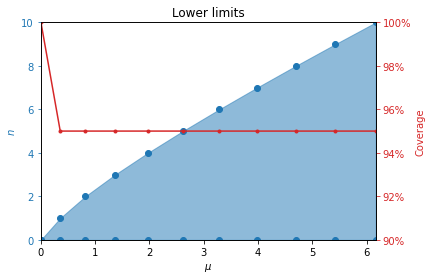

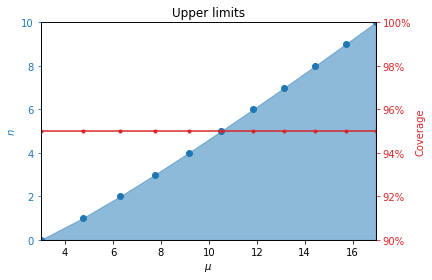

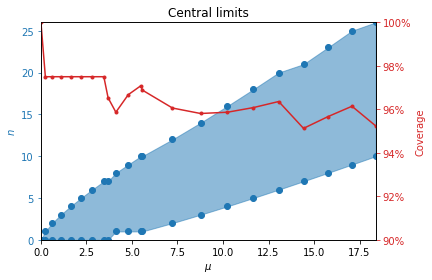

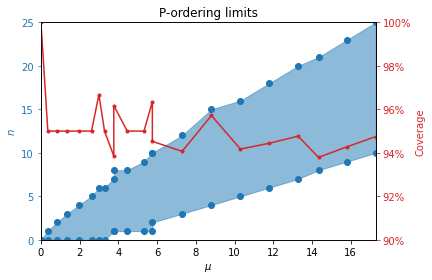

In [16]:
my_plot(lower_limits, lower_coverage, title="Lower limits")
my_plot(upper_limits, upper_coverage, title="Upper limits")
my_plot(central_limits, central_coverage, title="Central limits")
my_plot(p_limits, p_coverage, title="P-ordering limits")

# Bayesian interval estimation
The posterior is defined as
$$\pi_n(\mu)=\pi(\mu)\frac{L_n(\mu)}{n(x)}$$
but since the requirement is to use a constant prior $\pi(\mu)$, it can be rewritten as
$$\pi_n(\mu)=\frac{p(n;\mu)}{\text{normalization}}$$
where the normalization constant is defined so that
$$\int_0^\infty \pi_n(\mu)\text d\mu = 1$$

Since the credibility is defined as
$$Cr(n)=\int_{\mu\in f(n)} \pi_n(\mu)\text d\mu$$
and the credibility intervals are obtained by requiring that
$$\forall n,Cr(n)\geq c$$
it is necessary to be able to compute that integral over any given interval, including $[0,\infty)$.

One could approximate the integral using the trapezoidal rule and a finite number of $\mu$ values in a range $[0,M]$ whith $M\gg n$, since the probability $p(n;\mu)$ vanishes for fixed $n$ and $\mu\to\infty$.
The $\mu$ values may be chosen randomly within the interval, or using a fixed step.

However, this integral can also be computed analytically
$$\int\pi_n(\mu)\text d\mu=\frac{1}{n!\cdot\text{normalization}}\int e^{-\mu}\mu^n\text d\mu=-\frac{\Gamma(n+1,\mu)}{n!\cdot\text{normalization}}+\text{const}$$

In [ ]:
# TODO do the integral by random-sampling a range and compare the
# results with those from the analytical formula

In [1]:
# TODO Redraw the previous plots with also the credibility
# and not just the coverage